## Mini-description & imports

Далее представлен код для обработки трейн и тест датасета

(взаимодействие с data_test добавлено для репликации важных изменений трейна: удаление тех же самых колонок, заполнение nan и clip)

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs

from tqdm import tqdm

## 0. Dataset load

In [2]:
DATA_PATH = 'data/'

In [3]:
data = pl.read_parquet(DATA_PATH + 'train_ai_comp_final_dp.parquet')
data_test = pl.read_parquet(DATA_PATH + 'test_sber.parquet')

In [4]:
print('Data shape and size:', data.shape, round(data.estimated_size('gb'), 3))
print('Target info:', pl.Series(data.select(pl.col('target'))).value_counts())
data.head()

Data shape and size: (519615, 1080) 4.181
Target info: shape: (2, 2)
┌────────┬────────┐
│ target ┆ count  │
│ ---    ┆ ---    │
│ i64    ┆ u32    │
╞════════╪════════╡
│ 1      ┆ 18537  │
│ 0      ┆ 501078 │
└────────┴────────┘


id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,…,feature1041,feature1042,feature1043,feature1044,feature1045,feature1046,feature1047,feature1048,feature1049,feature1050,feature1051,feature1052,feature1053,feature1054,feature1055,feature1056,feature1057,feature1058,feature1059,feature1060,feature1061,feature1062,feature1063,feature1064,feature1065,feature1066,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076,__index_level_0__
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0,1,1761,1759,85,105469,191,46,0,6,95,0,0,20,191,1,6,50,60,7,248,248,347,91601,9,173,1722,5,8,9,174,1738,633,1545,50524,51771,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12045,12107,12510,21126,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264,0
1,0,1,1761,1759,120,105610,144,71,0,135,135,0,0,187,144,1,135,43,101,11,18,18,58,36890,9,184,1722,5,8,9,185,1738,633,1637,50524,51771,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,890,1759,141,105227,191,11,0,0,0,0,0,187,191,1,0,0,0,28,248,248,347,140184,9,248,1722,5,8,9,250,1738,633,1756,50524,51771,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33735,31242,12691,48682,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317,2
5,0,1,1599,966,30,102441,191,8,0,0,0,0,0,187,191,1,0,0,0,28,248,248,347,140184,9,248,1722,5,8,9,250,1738,633,1756,50524,51771,…,12291,101,0,0,114,118,118,118,0,0,0,0,0,0,0,5220,0,0,5810,5890,5890,5890,0,0,0,0,0,6872,8530,0,0,0,0,0,6872,8530,5
6,0,1,1761,1759,85,104006,191,2,0,0,46,0,0,2,191,1,0,1,21,3,248,248,347,140184,9,248,1722,5,8,9,250,1738,633,1756,16988,51771,…,26759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7642,0,0,0,0,0,0,7642,6


In [5]:
data.describe()

statistic,id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,…,feature1041,feature1042,feature1043,feature1044,feature1045,feature1046,feature1047,feature1048,feature1049,feature1050,feature1051,feature1052,feature1053,feature1054,feature1055,feature1056,feature1057,feature1058,feature1059,feature1060,feature1061,feature1062,feature1063,feature1064,feature1065,feature1066,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076,__index_level_0__
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,…,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0,519615.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",346719.616297,0.035674,1.0,1578.921015,1308.410059,76.30513,94386.514377,139.003685,41.42441,35.771227,94.050995,128.132198,50.524941,34.616953,118.291031,139.003685,68.484441,90.192433,83.639375,97.720279,15.90992,206.532127,206.545823,292.067833,102614.761406,8.999925,236.897284,1452.476484,4.999983,7.999942,8.999925,238.780245,1493.328499,625.663661,1673.258387,44766.006035,…,7934.009726,355.511271,106.313561,3.566054,498.005425,512.175759,512.175759,512.175759,4.143275,4.417738,5.281166,8.03104,11.93501,23.242918,50.353991,1605.583218,568.333647,9.22457,2506.899375,2611.354318,2611.354318,2611.354318,2915.599988,3018.929802,3278.940904,5142.696679,7200.840365,13172.209817,26496.441469,2915.599988,3018.929802,3278.940904,5142.696679,7200.840365,13172.209817,26496.441469,346719.616297
"""std""",200003.314087,0.185477,0.0,315.711163,660.446967,44.797241,22230.941664,74.734122,40.463193,56.144121,127.158066,119.933782,79.073395,54.347273,74.379883,74.734122,100.57392,123.750381,104.047542,116.998952,11.127697,75.265778,75.248052,101.946755,55807.968223,0.021446,34.019064,497.221173,0.007471,0.017438,0.021446,34.354549,477.478098,52.234518,286.164678,13156.304575,…,16928.752328,1645.63603,737.588696,117.891838,2208.292846,2283.61306,2283.61306,2283.61306,65.743359,68.994673,78.002152,112.043753,154.874119,258.699146,463.693224,4921.862946,2538.759632,304.95938,7129.596669,7504.652593,7504.652593,7504.652593,8948.724876,9129.809167,9669.071467,13822.903288,17892.604226,27943.888849,45663.346437,8948.724876,9129.809167,9669.071467,13822.903288,17892.604226,27943.888849,45663.346437,200003.314087
"""min""",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## 1. Drop constant and near-constant features

In [6]:
data['target'].value_counts(
    sort=True
).with_columns(
    (pl.col('count') / pl.col('count').sum()).round(3)
)

target,count
i64,f64
0,0.964
1,0.036


In [7]:
(1-0.9999) * len(data)

51.961499999994274

In [8]:
feature = []
value = []

for column in tqdm(data.columns):
    most_freq_value_frac = data[column].value_counts(
        sort=True
    ).with_columns(
        pl.col('count') / pl.col('count').sum()
    ).head(
        1
    )['count'].item()

    feature.append(column)
    value.append(most_freq_value_frac)

df_most_freq_value_fracs = pl.DataFrame({
    'feature': feature,
    'value': value,
})

100%|██████████████████████████████████████| 1080/1080 [00:07<00:00, 148.84it/s]


In [9]:
df_most_freq_value_fracs.filter(
    pl.col('value') > 0.9999
)

feature,value
str,f64
"""sample_ml_new""",1.0
"""feature23""",0.999985
"""feature26""",0.999994
"""feature27""",0.999987
"""feature28""",0.999985
"""feature66""",0.999931
"""feature68""",1.0
"""feature69""",1.0
"""feature144""",1.0


In [10]:
constant_features = df_most_freq_value_fracs.filter(
    pl.col('value') > 0.9999
)['feature'].to_numpy()

constant_features

array(['sample_ml_new', 'feature23', 'feature26', 'feature27',
       'feature28', 'feature66', 'feature68', 'feature69', 'feature144',
       'feature160', 'feature281', 'feature285', 'feature292',
       'feature301', 'feature302', 'feature321', 'feature325',
       'feature404', 'feature406', 'feature407', 'feature496',
       'feature511', 'feature617', 'feature625', 'feature661',
       'feature662', 'feature663', 'feature669', 'feature678',
       'feature682', 'feature683', 'feature685', 'feature686',
       'feature700', 'feature701', 'feature710', 'feature711',
       'feature719', 'feature744', 'feature748', 'feature756',
       'feature761', 'feature765', 'feature774', 'feature775',
       'feature801', 'feature802', 'feature806', 'feature807',
       'feature808', 'feature809', 'feature816', 'feature818',
       'feature819', 'feature886', 'feature889', 'feature910',
       'feature955', 'feature956', 'feature957', 'feature958',
       'feature959', 'feature960', 'feature96

In [11]:
data = data.drop(constant_features)
data_test = data_test.drop(constant_features)
print('Data shape and size:', data.shape, round(data.estimated_size('gb'), 3))

Data shape and size: (519615, 963) 3.728


## 2. Process missing values

In [12]:
data.select(pl.all().is_null()).sum().to_pandas().T.rename(columns={0: 'is_null_sum'}).query('is_null_sum > 0')

,is_null_sum
feature642,315324


In [13]:
data.select('feature642').unique()

feature642
f64
null
0.0
1.0


In [14]:
data = data.with_columns(
    pl.col('feature642').fill_null(-1).cast(pl.Int8)
)
data_test = data_test.with_columns(
    pl.col('feature642').fill_null(-1).cast(pl.Int8)
)
data.select('feature642').unique()

feature642
i8
0
1
-1


## 3. Check non featureX cols

In [15]:
data.select([col for col in data.columns if col[:7] != 'feature'])

id,target,__index_level_0__
i64,i64,i64
0,0,0
1,0,1
2,0,2
5,0,5
6,0,6
7,0,7
8,0,8
9,0,9
10,0,10


In [16]:
data.select(
    pl.col('id').n_unique(),
    pl.col('__index_level_0__').n_unique(),
    pl.len()
)

id,__index_level_0__,len
u32,u32,u32
519615,519615,519615


In [17]:
data = data.drop('id', '__index_level_0__')
data_test = data_test.drop('id', '__index_level_0__')
data.head(1)

target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature24,feature25,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,…,feature1040,feature1041,feature1042,feature1043,feature1044,feature1045,feature1046,feature1047,feature1048,feature1049,feature1050,feature1051,feature1052,feature1053,feature1054,feature1055,feature1056,feature1057,feature1058,feature1059,feature1060,feature1061,feature1062,feature1063,feature1064,feature1065,feature1066,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,1761,1759,85,105469,191,46,0,6,95,0,0,20,191,1,6,50,60,7,248,248,347,91601,173,1722,174,1738,633,1545,50524,51771,16130,3652,85495,14172,11665,16298,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12045,12107,12510,21126,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264


## 4. Check correlations

In [18]:
data_for_corr = pl.concat(
    [
        data.filter(pl.col('target') == 0).sample(n=100_000, seed=42),
        data.filter(pl.col('target') == 1)
    ],
    how='vertical'
)

corrs = []
for i, feat1 in tqdm(enumerate(data_for_corr.columns[1:], start=1), total=len(data_for_corr.columns[1:])):
    for j, feat2 in enumerate(data_for_corr.columns[1+i:-1], start=1):
        corrs.append(
            [feat1, feat2, data_for_corr.select(pl.corr(feat1, feat2, method='spearman')).item()]
        )

corrs = pl.from_records(corrs, schema=['feat1', 'feat2', 'corr'])
corrs.head(3)

100%|█████████████████████████████████████████| 960/960 [27:54<00:00,  1.74s/it]


feat1,feat2,corr
str,str,f64
"""feature1""","""feature2""",0.578284
"""feature1""","""feature3""",-0.020851
"""feature1""","""feature4""",-0.069082


In [19]:
super_correlated = corrs.filter(pl.col('corr').abs() >= 0.99)

features_correlated = super_correlated.filter(
    ~pl.col('feat1').is_in(super_correlated['feat2'].unique())  # to avoid cases when cor(x, y) = 0.99, cor(y, z) = 0.99, cor(x, z) = 0
)['feat2'].to_list()

In [20]:
features_correlated = super_correlated.filter(
    ~pl.col('feat1').is_in(super_correlated['feat2'].unique())
)['feat2'].to_numpy()
features_correlated

array(['feature812', 'feature814', 'feature933', 'feature934',
       'feature13', 'feature858', 'feature351', 'feature853',
       'feature863', 'feature10', 'feature11', 'feature15', 'feature347',
       'feature859', 'feature868', 'feature20', 'feature21', 'feature29',
       'feature32', 'feature30', 'feature34', 'feature536', 'feature39',
       'feature40', 'feature576', 'feature577', 'feature42', 'feature362',
       'feature363', 'feature364', 'feature365', 'feature50', 'feature51',
       'feature372', 'feature373', 'feature376', 'feature377',
       'feature380', 'feature381', 'feature382', 'feature383',
       'feature394', 'feature397', 'feature399', 'feature131',
       'feature403', 'feature483', 'feature408', 'feature409',
       'feature410', 'feature132', 'feature411', 'feature484',
       'feature412', 'feature413', 'feature414', 'feature415',
       'feature416', 'feature417', 'feature418', 'feature419',
       'feature420', 'feature421', 'feature422', 'feature423',


In [21]:
data = data.drop(features_correlated)
data_test = data_test.drop(features_correlated)
print('Data shape and size:', data.shape, round(data.estimated_size('gb'), 3))

Data shape and size: (519615, 641) 2.478


## 5. Clip outliers

In [22]:
numeric_feature_threshold = data.shape[0] * 0.5
print(numeric_feature_threshold)

259807.5


In [23]:
features_like_numeric = [col for col in data.columns if (data[col].n_unique() > numeric_feature_threshold)]
print('Number of features to clip: ', len(features_like_numeric))

Number of features to clip:  52


In [24]:
for feat in features_like_numeric: 
    low, upp = data[feat].quantile(0.01), data[feat].quantile(0.99)

    data = data.with_columns(
        pl.col(feat).clip(lower_bound=low, upper_bound=upp)
    )
    data_test = data_test.with_columns(
        pl.col(feat).clip(lower_bound=low, upper_bound=upp)
    )

## 6. Fix formats

In [25]:
print('Size before format change:', round(data.estimated_size('gb'), 3))

for name in data.select(cs.by_dtype(pl.INTEGER_DTYPES)).columns:
    try:
        data = data.with_columns(
            pl.col(name).cast(pl.Int8)
        )
        continue
    except Exception as e:
        pass

    try:
        data = data.with_columns(
            pl.col(name).cast(pl.Int16)
        )
        continue
    except Exception as e:
        pass

    try:
        data = data.with_columns(
            pl.col(name).cast(pl.Int32)
        )
        continue
    except Exception as e:
        pass

print('Size after format change:', round(data.estimated_size('gb'), 3))

Size before format change: 2.478
Size after format change: 0.659


In [26]:
data.select(cs.by_dtype(pl.FLOAT_DTYPES))

shape: (0, 0)
┌┐
╞╡
└┘

In [27]:
column_types = data.dtypes
column_types = [str(x) for x in column_types]

np.unique(column_types, return_counts=True)

(array(['Int16', 'Int32', 'Int8'], dtype='<U5'), array([259, 154, 228]))

check format change for x+y feature

In [28]:
data.head(3)

target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature12,feature14,feature16,feature17,feature18,feature19,feature22,feature24,feature25,feature31,feature33,feature35,feature36,feature37,feature38,feature41,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature52,feature53,feature54,feature55,…,feature992,feature993,feature994,feature996,feature997,feature998,feature999,feature1000,feature1001,feature1002,feature1003,feature1004,feature1035,feature1036,feature1037,feature1038,feature1042,feature1043,feature1045,feature1049,feature1050,feature1051,feature1052,feature1053,feature1054,feature1055,feature1056,feature1057,feature1059,feature1063,feature1064,feature1065,feature1066,feature1067,feature1068,feature1069,feature1076
i8,i16,i16,i16,i32,i16,i16,i8,i16,i16,i16,i16,i16,i16,i8,i16,i32,i16,i16,i16,i32,i32,i16,i32,i16,i16,i32,i16,i16,i32,i32,i16,i16,i16,i16,i32,i32,…,i16,i16,i16,i8,i8,i8,i8,i8,i8,i16,i16,i16,i32,i32,i16,i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i32,i32,i32,i32,i32,i32,i32,i32,i32
0,1761,1759,85,105469,191,46,0,6,95,20,1,50,60,7,248,91601,173,1722,633,50524,16130,3652,85495,14172,7705,19131,6511,12018,31287,27091,0,0,0,0,30270,27157,…,5,8,16,1,0,0,2,1,2,3,6,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12045,12107,12510,21126,28913,48985,84264,84264
0,1761,1759,120,105610,144,71,0,135,135,187,1,43,101,11,18,36890,184,1722,633,50524,18999,3652,85495,14172,7705,59900,6511,12018,116284,141739,0,0,0,0,112320,138924,…,4,10,22,0,0,0,3,0,2,3,9,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,890,1759,141,105227,191,11,0,0,0,187,1,0,0,28,248,140184,248,1722,633,50524,65748,3652,85495,14172,7705,11110,6511,12018,261217,284839,0,0,0,0,252909,278364,…,9,24,40,1,1,2,3,3,5,8,23,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33735,31242,12691,48682,55949,70006,113317,113317


In [29]:
(data['feature4'] + data['feature8']).head(3)

feature4
i32
105475
105745
105227


## 7. Saving the data

In [30]:
data.write_parquet(DATA_PATH + 'data_cleaned.parquet')
data_test.write_parquet(DATA_PATH + 'data_test_cleaned.parquet')

---

## Bonus: boostings baselines

In [31]:
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report

In [32]:
data['target'].unique_counts()

target
u32
501078
18537


In [33]:
data['target'].to_pandas()

0         0
1         0
2         0
3         0
4         0
         ..
519610    0
519611    0
519612    0
519613    0
519614    1
Name: target, Length: 519615, dtype: int8

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target').to_pandas(), data['target'].to_pandas().values, test_size=0.25, random_state=42, stratify=data['target'].to_pandas()
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((389711, 640), (129904, 640), (389711,), (129904,))

In [35]:
%%time

model = CatBoostClassifier(allow_writing_files=False, verbose=False)
model.fit(X_train, y_train)

CPU times: user 14min 16s, sys: 7.7 s, total: 14min 24s
Wall time: 2min 16s


In [36]:
%%time

y_pred = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, (y_pred > round(y_train.mean(), 3)).astype(int)))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}')
# ROC-AUC: 0.757

              precision    recall  f1-score   support

           0       0.98      0.73      0.84    125270
           1       0.08      0.65      0.15      4634

    accuracy                           0.73    129904
   macro avg       0.53      0.69      0.49    129904
weighted avg       0.95      0.73      0.81    129904

ROC-AUC: 0.757
CPU times: user 691 ms, sys: 27.1 ms, total: 718 ms
Wall time: 223 ms


In [37]:
%%time

model = LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 13903, number of negative: 375808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100248
[LightGBM] [Info] Number of data points in the train set: 389711, number of used features: 640
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035675 -> initscore=-3.296974
[LightGBM] [Info] Start training from score -3.296974
CPU times: user 46.4 s, sys: 2.32 s, total: 48.8 s
Wall time: 11.6 s


LGBMClassifier()

In [38]:
%%time

y_pred = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, (y_pred > round(y_train.mean(), 3)).astype(int)))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}')
# ROC-AUC: 0.757

              precision    recall  f1-score   support

           0       0.98      0.72      0.83    125270
           1       0.08      0.65      0.14      4634

    accuracy                           0.72    129904
   macro avg       0.53      0.69      0.49    129904
weighted avg       0.95      0.72      0.81    129904

ROC-AUC: 0.755
CPU times: user 1.23 s, sys: 148 ms, total: 1.38 s
Wall time: 524 ms


In [39]:
%%time

model = XGBClassifier()
model.fit(X_train, y_train)

CPU times: user 1min 5s, sys: 10.1 s, total: 1min 16s
Wall time: 11.9 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
%%time

y_pred = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, (y_pred > round(y_train.mean(), 3)).astype(int)))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred):.3f}')
# ROC-AUC: 0.735

              precision    recall  f1-score   support

           0       0.98      0.74      0.85    125270
           1       0.08      0.61      0.14      4634

    accuracy                           0.74    129904
   macro avg       0.53      0.68      0.49    129904
weighted avg       0.95      0.74      0.82    129904

ROC-AUC: 0.741
CPU times: user 1.45 s, sys: 747 ms, total: 2.19 s
Wall time: 300 ms


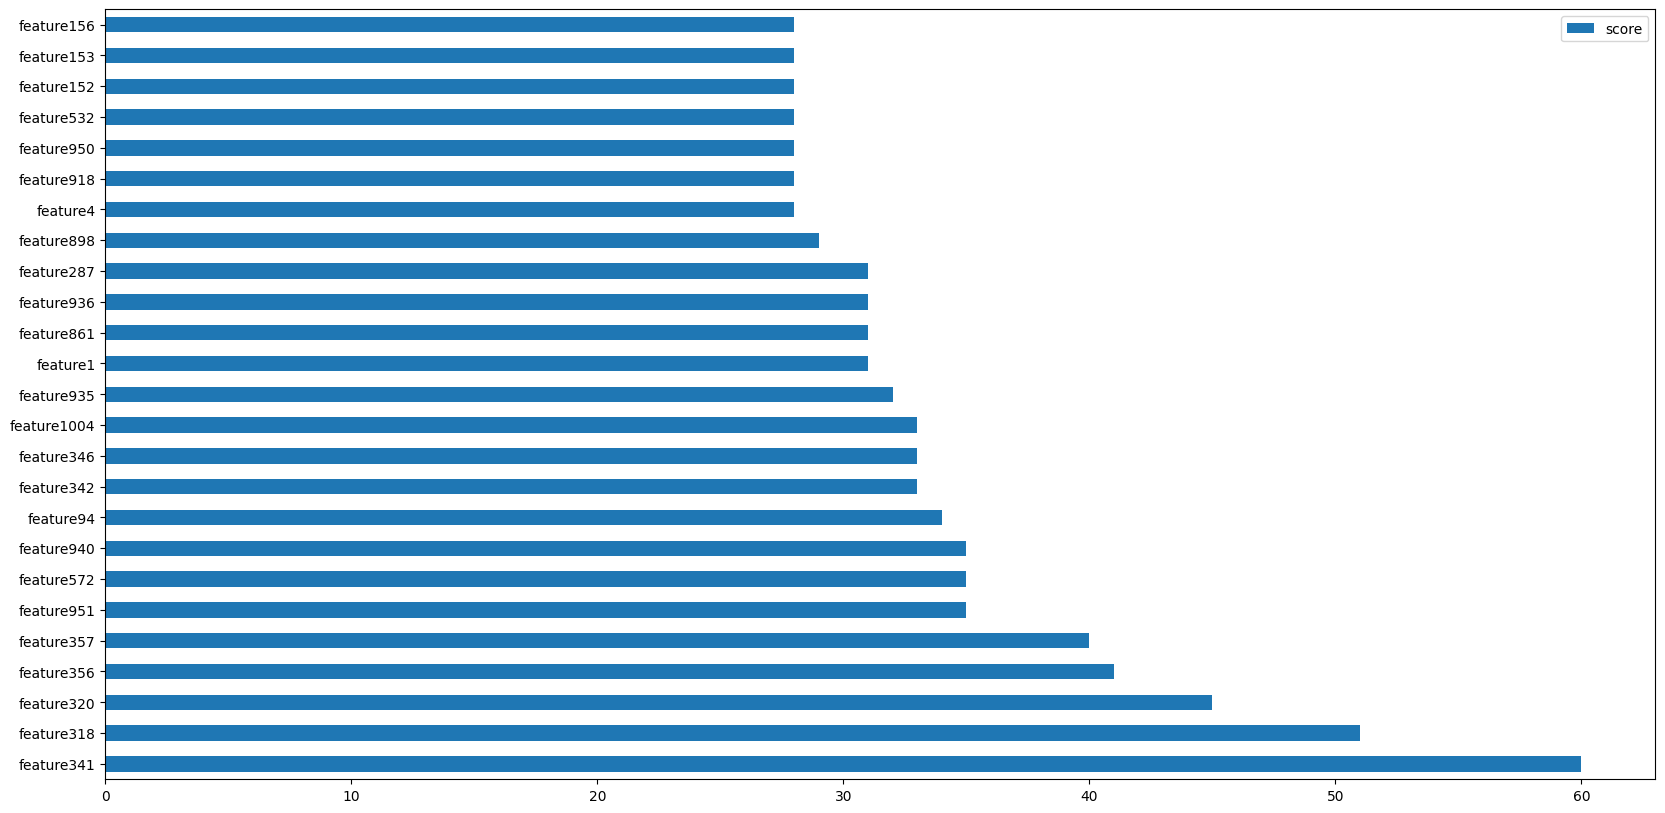

In [41]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_fi = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending=False)
data_fi.nlargest(25, columns='score').plot(kind='barh', figsize = (20, 10))  # plot top 25 features
plt.show()

## 1st submission

In [42]:
data_test = pl.read_parquet(DATA_PATH + 'data_test_cleaned.parquet')
# data_test = data_test.select(
#     col for col in data.columns if col in data_test.columns
# )
data_test

feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature12,feature14,feature16,feature17,feature18,feature19,feature22,feature24,feature25,feature31,feature33,feature35,feature36,feature37,feature38,feature41,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature52,feature53,feature54,feature55,feature56,…,feature992,feature993,feature994,feature996,feature997,feature998,feature999,feature1000,feature1001,feature1002,feature1003,feature1004,feature1035,feature1036,feature1037,feature1038,feature1042,feature1043,feature1045,feature1049,feature1050,feature1051,feature1052,feature1053,feature1054,feature1055,feature1056,feature1057,feature1059,feature1063,feature1064,feature1065,feature1066,feature1067,feature1068,feature1069,feature1076
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1696,458,26,102479,22,16,0,121,69,47,18,2,1,10,7,119624,77,1638,536,37047,2309,3652,85495,14172,7705,33578,6511,12018,64527,588431,0,1961,0,0,62218,573496,0,…,4,10,21,0,0,2,2,2,3,2,9,21,0,0,0,0,1724,7888,14913,0,0,0,0,0,0,0,0,0,0,254,0,355,308,779,7740,9577,9577
1688,53,78,103922,191,64,0,0,65,28,1,29,1,5,248,140184,248,300,633,50524,57098,3652,16306,81,7705,48044,6511,11233,80296,453151,0,0,4985,15442,27559,359735,0,…,6,12,21,0,0,2,2,2,3,4,10,19,0,0,0,0,0,8382,16284,0,0,0,0,0,0,0,0,6285,9829,24766,48600,46029,65113,79401,109240,153820,153820
1689,13,81,104111,191,4,0,0,125,43,1,0,0,10,248,140184,248,632,633,32721,41464,3652,85495,14172,7705,41415,19,66,404623,597648,0,0,19,70,392709,582546,0,…,6,11,24,0,0,0,2,0,1,4,9,22,0,0,0,0,0,0,0,0,0,0,0,0,0,2030,0,0,0,0,0,0,0,0,0,0,0
1761,1759,44,102433,191,4,0,0,135,54,1,75,135,11,248,140184,248,1722,633,50524,65748,3652,85495,14172,7705,59900,6511,12018,61497,498533,0,0,0,0,59301,486202,0,…,6,12,24,0,0,3,4,3,6,8,15,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1761,1759,77,102010,191,34,0,0,83,187,1,2,72,6,248,140184,248,1722,633,50524,65748,3652,85495,14172,7705,59900,6511,12018,76431,108069,0,0,0,559,73752,105055,0,…,4,7,12,0,0,2,2,2,3,3,6,11,139,0,323,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1761,1759,122,105798,49,16,0,0,187,17,1,14,74,15,183,0,248,1722,633,12688,65748,3652,85495,14172,7705,59900,6511,12018,523584,528937,0,0,0,0,508520,515851,0,…,5,11,23,0,0,2,1,2,2,3,11,23,0,0,326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1602,1759,67,102229,14,2,0,0,19,187,1,0,1,1,217,0,248,800,633,50524,44809,3652,85495,14172,7705,46905,6511,12018,305775,401053,0,0,0,0,296322,391454,0,…,6,14,29,0,0,2,3,2,4,4,12,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62618,62618
1690,1553,106,103036,191,22,0,0,0,58,1,0,0,28,248,140184,248,1722,633,50524,65748,3652,85495,14172,7705,21915,6511,12018,408025,383080,0,0,0,0,339696,334893,0,…,7,12,24,2,0,2,2,4,5,7,13,26,51732,16449,13511,61060,0,0,0,0,0,0,0,0,0,0,0,113,213,0,0,0,0,0,0,0,0
1107,767,18,94011,191,23,0,0,8,187,1,7,7,0,248,140184,248,1722,633,49681,65748,3652,85495,14172,7705,14194,6511,12018,431027,587485,0,0,0,0,418424,572716,0,…,5,11,20,0,0,2,2,2,3,4,10,20,3331,2761,6437,6090,0,0,0,0,0,0,0,0,0,0,0,3607,5510,20743,23650,45990,35284,68398,108656,154593,154593


In [43]:
%%time

X_train, y_train = data.drop('target').to_pandas(), data['target'].to_pandas().values

model = CatBoostClassifier(allow_writing_files=False, verbose=False)
model.fit(X_train, y_train)

CPU times: user 18min 43s, sys: 9.23 s, total: 18min 52s
Wall time: 3min


In [44]:
%%time

X_test = data_test.drop('target').to_pandas()

y_pred = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred > round(y_train.mean(), 3)).astype(int)

CPU times: user 904 ms, sys: 559 ms, total: 1.46 s
Wall time: 342 ms


In [45]:
submission = pl.read_parquet(DATA_PATH + 'test_sber.parquet').select('id').to_pandas()

submission['target_prob'] = y_pred
submission['target_bin'] = y_pred_binary
submission.head(3)

,id,target_prob,target_bin
0,3,0.010903,0
1,4,0.018156,0
2,12,0.035269,0


In [46]:
submission.to_csv('submission_1.csv', index=False)

In [47]:
submission

,id,target_prob,target_bin
0,3,0.010903,0
1,4,0.018156,0
2,12,0.035269,0
3,16,0.011283,0
4,20,0.069019,1
...,...,...,...
173428,693043,0.130796,1
173429,693044,0.144447,1
173430,693045,0.077651,1
173431,693046,0.228700,1
